# Segmentation of Indian Traffic

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import urllib.request


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [3]:
os.chdir('/gdrive/My Drive/Image_Segmentation/segmentation')
os.listdir()

['data',
 'Preprocessing.csv',
 'logs',
 'Model_save',
 'Segmentation_Assignment.ipynb',
 'tf_ckpts',
 'Copy of Segmentation_Assignment.ipynb',
 'test_image.png',
 'Preprocessing_2.csv',
 'preprocessed_data.csv',
 'Reference_Preptrained_Unet.ipynb',
 'model4.png',
 'model.png']

In [ ]:
# First check both image and Mask folder contains same number of sub-folder with same name respectively
image_sub_folder = sorted(os.listdir('data/images'))
mask_sub_folder = sorted(os.listdir('data/mask'))
print('Length of image folder',len(image_sub_folder))
print('Length of image folder',len(mask_sub_folder))
print('Both Image and Mask contains same folder names - ',image_sub_folder == (mask_sub_folder))

Length of image folder 143
Length of image folder 143
Both Image and Mask contains same folder names -  True


In [ ]:
def return_file_names_df():
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    img_path = []
    mask_path = []

    for i in tqdm(image_sub_folder):
      img_loc = sorted(os.listdir('data/images/'+str(i)))
      mask_loc = sorted(os.listdir('data/mask/'+str(i)))

      for file_I,file_M in zip(img_loc,mask_loc):
        img_pa = os.path.join('data/images/'+str(i),file_I)
        mask_pa = os.path.join('data/mask/'+str(i),file_M)
        img_path.append(img_pa)
        mask_path.append(mask_pa)

    data_df = pd.DataFrame({'image': img_path,'json': mask_path})

    
    return data_df

In [ ]:
data_df = return_file_names_df()
data_df.head()

100%|██████████| 143/143 [00:09<00:00, 15.24it/s]


,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    all_attributes = [] # storing all attributes
    all_labels = [] # stroing all label values of each row
    
    for i in tqdm(range(data_df.shape[0])):
      f = open(data_df.json[i],) 
      data = json.load(f) 
      for j in data['objects']:
        all_attributes.append(j)
      f.close()

    # to get unique label count
    for k in tqdm(range(len(all_attributes))):
     all_labels.append( all_attributes[k]['label'])


    # get unique 
    unique_labels = list(set(all_labels))
    print('Number of unique labels ',len(unique_labels))

    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

100%|██████████| 434321/434321 [00:00<00:00, 1934991.27it/s]

Number of unique labels  40


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [4]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [5]:
class_values = sorted(list(set(label_clr.values())))
print('Class labels', class_values)
class_values = [int(x / 10 )for x in class_values]
print('Class labels', class_values)
print('Number of unique class labels',len(set(label_clr.values())))

Class labels [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
Class labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Number of unique class labels 21


In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
 
    f = open(file,)
    data = json.load(f)
    label,vertexlist=[],[]
    for obj in data['objects']:
        label.append(obj['label'])
        vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
    w= data['imgWidth']
    h=data['imgHeight']

    return w, h, label, vertexlist

In [ ]:
w, h, labels, vertexlist = get_poly('data/mask/201/frame0029_gtFine_polygons.json')

In [ ]:
def grader_3(file):

  w, h, labels, vertexlist = get_poly(file)
  print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
        and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

Before <PIL.ImageDraw.ImageDraw object at 0x7fc5eb03f5c0>
After <PIL.ImageDraw.ImageDraw object at 0x7fc5eb03f5c0>
(28, 28, 3)
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6

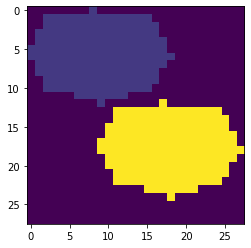

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
print('Before',img1)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =10)
# writing the second polygon
img1.polygon(x2, fill =60)
print('After',img1)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
#os.makedirs('data/output')
def compute_masks(data_df):
    mask=[]
    for file in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(file)

        img= Image.new("RGB",(w,h)) 
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i])>1):
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        new_file=file.replace('mask','output')
        new_file=new_file.replace('json','png')
        os.makedirs('data/output/'+file.split('/')[2],exist_ok=True)
        im.save(new_file)
        mask.append(new_file)
    data_df['mask']=mask
    
    return data_df


In [ ]:
data_df = compute_masks(data_df)

100%|██████████| 4008/4008 [05:14<00:00, 12.75it/s]


In [ ]:
data_df.head(5)

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
data_df.to_csv('Preprocessing_2.csv',index=False)

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


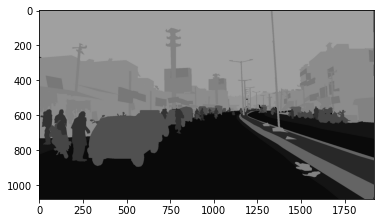

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')   
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    #print(my_img[:,:,0])
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [6]:
data_df = pd.read_csv('preprocessed_data.csv')
data_df.drop(['Unnamed: 0','json'],inplace=True,axis=1)
data_df.head(2)

,image,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/output/201/frame0299_gtFine_polygons.png


# Task 2: Applying Unet to segment the images

**Channels Last** <pre>. Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels] </pre>

**Channels First**
<pre>
Image data is represented in a three-dimensional array where the first channel represents the color channels, e.g. [channels][rows][cols].
</pre>

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [7]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 460kB 47.5MB/s 
     |████████████████████████████████| 3.0MB 50.8MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [8]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 10.3MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
!pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 


In [10]:
# install required Package
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import Model
import random as rn

In [11]:
# here dir_path is the route directory where all the images and segmentation maps are there
dir_path = "data/images/"
dir_path_output = "data/output/"
file_names = set()
file_names_output = set()
for folder in tqdm(os.listdir(dir_path)):

    dir_paths = "data/images/" +str(folder)
    for i in os.listdir(dir_paths):
      path= (i.split('.')[0].split('_')[0])
      file_names.add(str(folder) +str('/')+path)



for folder in tqdm(os.listdir(dir_path_output)):
    dir_paths = "data/output/" +str(folder)
    for i in os.listdir(dir_paths):
      path= (i.split('.')[0].split('_')[0])
      file_names_output.add(str(folder) +str('/')+path)


100%|██████████| 143/143 [00:11<00:00, 12.53it/s]


In [12]:
print('Total_number of unique files', len(file_names))
print('Total_number of unique files- Output Mask folder', len(file_names_output))

Total_number of unique files 4008
Total_number of unique files- Output Mask folder 4008


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(list(file_names), test_size=0.20, random_state=42)

In [14]:
X_train[:5]

['280/frame0574',
 '283/frame3574',
 '252/frame1536',
 '338/frame61726',
 '231/frame3047']

In [15]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [16]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,BatchNormalization, ReLU, Reshape,Flatten
from tensorflow.keras.models import Model
import random as rn
import keras

In [17]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
# Create Model
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax',encoder_freeze=True, input_shape=(224,224,3))

85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

In [18]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [19]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

def normalize_image(mask):
    mask = mask/255
    return mask
    

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    #CLASSES = class_values
    CLASSES = list(np.unique(list(label_clr.values()))) 
    #classes=CLASSES
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, images_dir,images_dir_mask ,file_names,classes, isTest):
        print(classes)
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [os.path.join(images_dir, image_id+'_leftImg8bit.jpg') for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [os.path.join(images_dir_mask, image_id+"_gtFine_polygons.png") for image_id in self.ids]
        # giving labels for each class
        #self.class_values = [self.CLASSES.index(cls) for cls in classes]
        self.class_values = CLASSES
        print(self.class_values)
        # As per Hint - Augumentation not required for Validation data
        self.isTest = isTest

    def __getitem__(self, i):
        
        # read data
        #print('Reading a data')

        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (224, 224),interpolation=cv2.INTER_AREA) 
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (224, 224),interpolation=cv2.INTER_AREA) 

        image_mask = mask
      
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        #print('MASK',image_mask.shape)
        
        #Augumentation only for train
        if self.isTest == False:
            a = np.random.uniform()

            if a<0.2:
                image = aug2.augment_image(image)
                #image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                #image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                #image_mask = aug4.augment_image(image_mask)
            else:
                image = aug5.augment_image(image)
                #image_mask = image_mask

            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        #print(type(batch))
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [20]:
# Dataset for train images
CLASSES = list(np.unique(list(label_clr.values()))) 
train_dataset = Dataset(dir_path,dir_path_output,X_train, classes=CLASSES,isTest=False)
test_dataset  = Dataset(dir_path,dir_path_output,X_test, classes=CLASSES,isTest=True)




[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [21]:
#UNET 
train_dataloader = Dataloder(train_dataset, batch_size=32, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=32, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (32, 224, 224, 3)
assert train_dataloader[0][1].shape == (32, 224, 224, 21)

(32, 224, 224, 3)


In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

In [37]:
# TensorBoard Creation

ACCURACY_THRESHOLD_test = 0.5
class myCallback(tf.keras.callbacks.Callback): 

    def on_epoch_end(self, epoch, logs={}):

      if(logs.get('val_iou_score') >= ACCURACY_THRESHOLD_test and logs.get('iou_score') >= ACCURACY_THRESHOLD_test): 
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD_test*100))   
        self.model.stop_training = True
        
        

early_stop_iou_scores = myCallback()


%load_ext tensorboard
import datetime
folder_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create log folder - TensorBoard
log_dir="/gdrive/My Drive/Image_Segmentation/segmentation/logs/fit/" + folder_name
tensorboard_callback =TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

print('Folder_name', folder_name)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

red_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

filepath="/gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_updated-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_iou_score',  verbose=1, save_best_only=True, mode='max')



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Folder_name 20201103-013529


In [40]:
# TensorBoard Creation

ACCURACY_THRESHOLD_test = 0.5
class myCallback(tf.keras.callbacks.Callback): 

    def on_epoch_end(self, epoch, logs={}):

      if(logs.get('val_iou_score') >= ACCURACY_THRESHOLD_test and logs.get('iou_score') >= ACCURACY_THRESHOLD_test): 
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD_test*100))   
        self.model.stop_training = True
        
        

early_stop_iou_scores = myCallback()


%load_ext tensorboard
import datetime
folder_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create log folder - TensorBoard
log_dir="/gdrive/My Drive/Image_Segmentation/segmentation/logs/fit/" + folder_name
tensorboard_callback =keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

print('Folder_name', folder_name)


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

red_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

filepath="/gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_updated-{epoch:02d}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_iou_score',  verbose=1, save_best_only=True, mode='max')



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Folder_name 20201103-013833


In [33]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import tensorflow as tf
import keras
optim = keras.optimizers.Adam(learning_rate=0.001)

focal_loss = sm.losses.cce_dice_loss

In [ ]:


optim = keras.optimizers.Adam(learning_rate=0.001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optimizer = optim, loss=focal_loss, metrics=[iou_score])

In [ ]:
#UNET and Res34 step per epoch 100 -  Batch size 32
history = model.fit_generator(train_dataloader, epochs=150,
                              validation_data=test_dataloader ,
                              callbacks = [early_stop_iou_scores,checkpoint,red_lr,tensorboard_callback,early_stop ])

Epoch 1/150
100/100 [==============================] - 2544s 25s/step - loss: 2.1520 - iou_score: 0.0745 - val_loss: 2.0553 - val_iou_score: 0.0731

Epoch 00001: val_iou_score improved from -inf to 0.07311, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_news-01.h5
Epoch 2/150
100/100 [==============================] - 289s 3s/step - loss: 1.6903 - iou_score: 0.1314 - val_loss: 1.7294 - val_iou_score: 0.1256

Epoch 00002: val_iou_score improved from 0.07311 to 0.12563, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_news-02.h5
Epoch 3/150
100/100 [==============================] - 280s 3s/step - loss: 1.4491 - iou_score: 0.3021 - val_loss: 1.4400 - val_iou_score: 0.3324

Epoch 00003: val_iou_score improved from 0.12563 to 0.33239, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_news-03.h5
Epoch 4/150
100/100 [==============================] - 271s 3s/step - loss: 1

In [3]:
#reconstruction 1 - Above training stopped unfortunately, so using best model weight to continue the processing
import keras
model = keras.models.load_model("/gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_news-30.h5")
history = model.fit_generator(train_dataloader, epochs=150,
                              validation_data=test_dataloader ,
                              callbacks = [early_stop_iou_scores,checkpoint,red_lr,tensorboard_callback,early_stop ])



Epoch 1/150
  2/100 [..............................] - ETA: 21:41 - loss: 0.8241 - iou_score: 0.4667
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.053651). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
100/100 [==============================] - 332s 3s/step - loss: 0.8784 - iou_score: 0.4634 - val_loss: 0.8101 - val_iou_score: 0.4690

Epoch 00001: val_iou_score improved from 0.42296 to 0.46905, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_updated-01.h5
Epoch 2/150
100/100 [==============================] - 294s 3s/step - loss: 0.8825 - iou_score: 0.4609 - val_loss: 0.7961 - val_iou_score: 0.4723

Epoch 00002: val_iou_score improved from 0.46905 to 0.47231, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_updated-02.h5
Epoch 3/150
100/100 [==============================

In [2]:
#reconstruction 2 -  Above training stopped due to exceed RAM usage in colab, so using best model weight to continue the processing

import keras
model = keras.models.load_model("/gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_news-42.h5")
history = model.fit_generator(train_dataloader, epochs=150,
                              validation_data=test_dataloader ,
                              callbacks = [early_stop_iou_scores,checkpoint,red_lr,tensorboard_callback,early_stop ])


Epoch 1/150
100/100 [==============================] - 2844s 25s/step - loss: 0.7917 - iou_score: 0.5001 - val_loss: 0.7816 - val_iou_score: 0.5003

Epoch 00001: val_iou_score improved from -inf to 0.50034, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/better_model_news-01.h5

Reached 50.00% accuracy, so stopping training!!



In [ ]:
# /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/best_model_news-17.h5 - Best weight location
# best - Epoch 00060: val_iou_score improved from 0.44134 to 0.44197, saving model to /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/best_model_news-60.h5
# best - /gdrive/My Drive/Image_Segmentation/segmentation/Model_save/best_model_news-01.h5  = 0.472

In [ ]:
# The below grapgh is only from Epoch 1 to Epoch 40
# Recondtsruction 1-  Stopped unfortunately due to RAM limitage reached -  unable to draw the grap
# Recondtsruction 2 -  Achieved expected result in first epoch itself -  So graph not required.

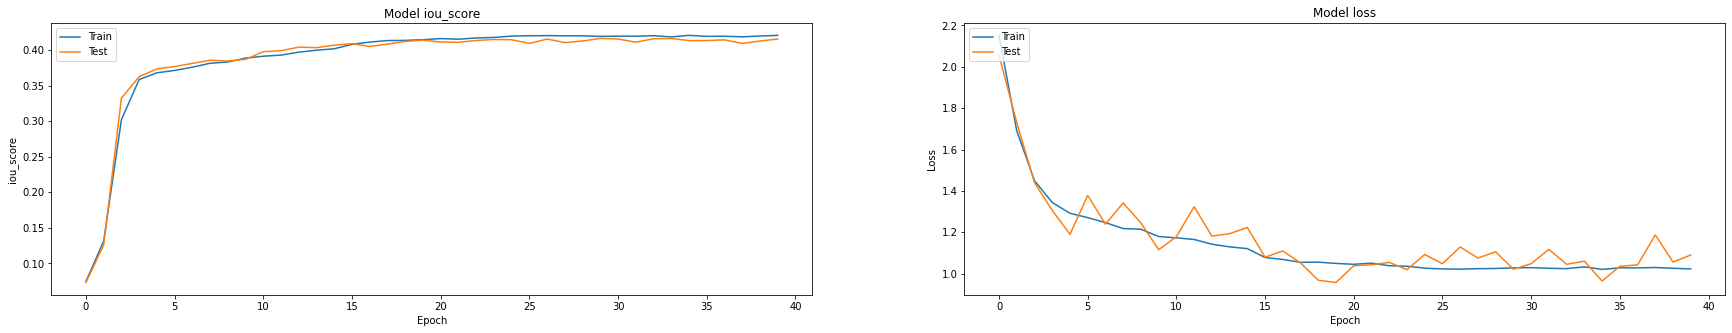

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

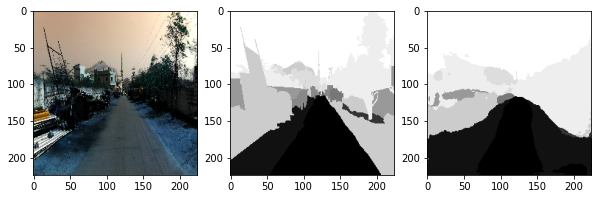

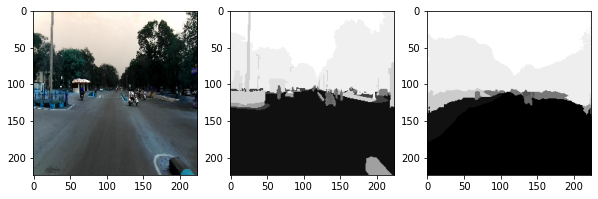

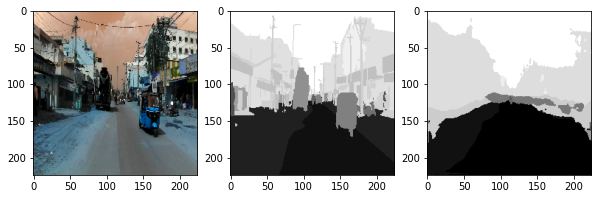

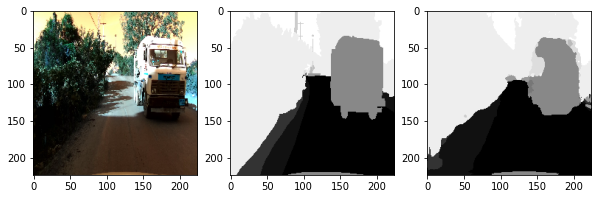

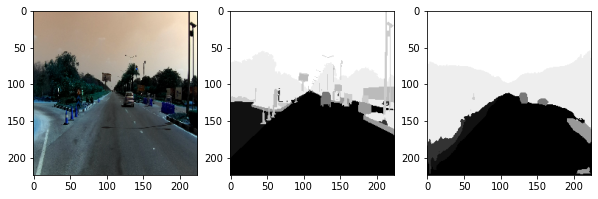

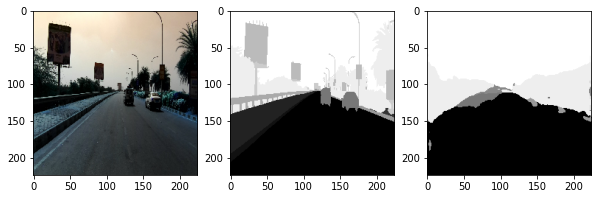

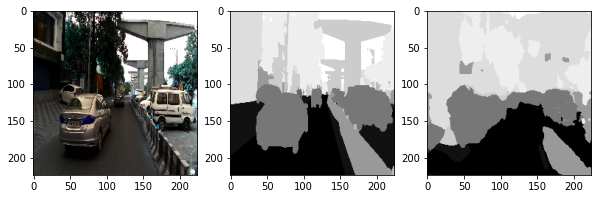

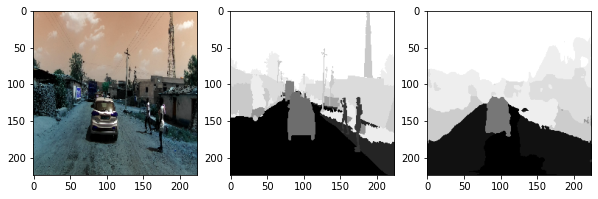

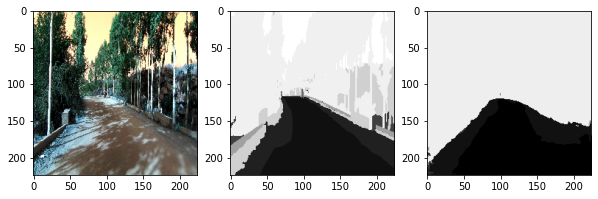

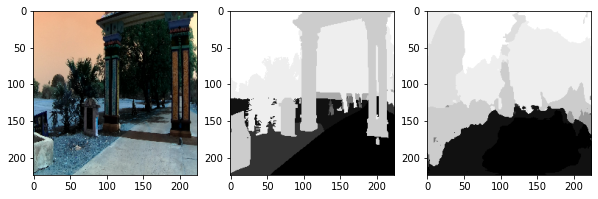

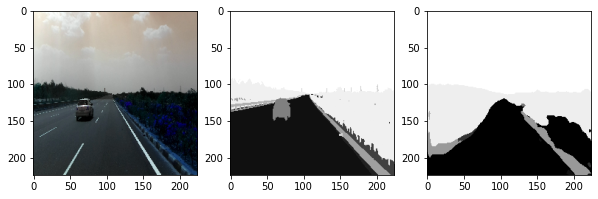

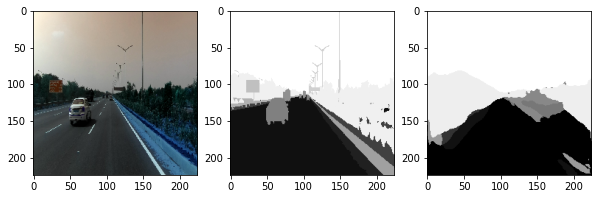

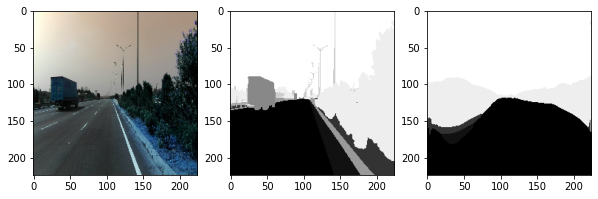

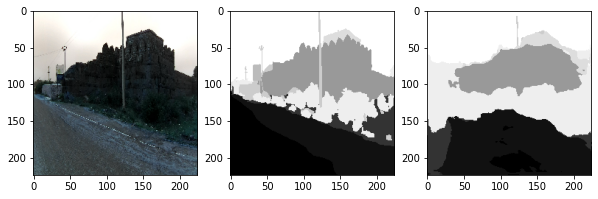

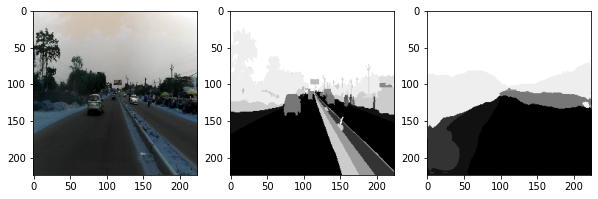

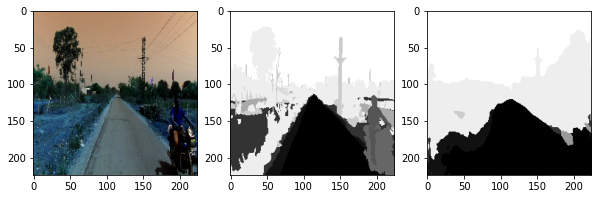

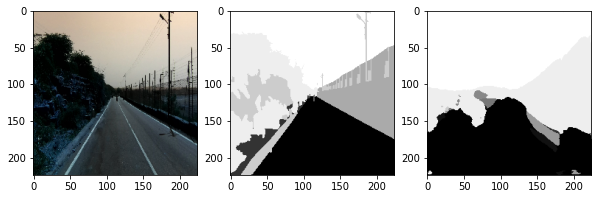

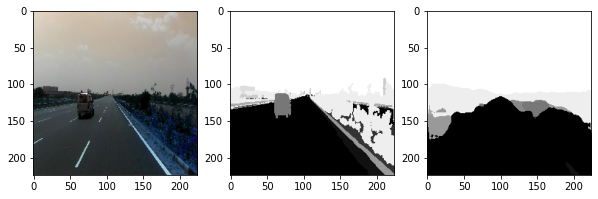

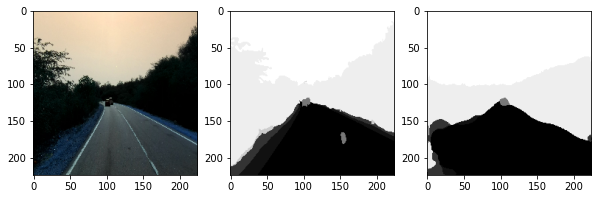

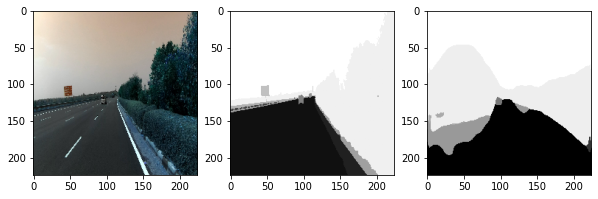

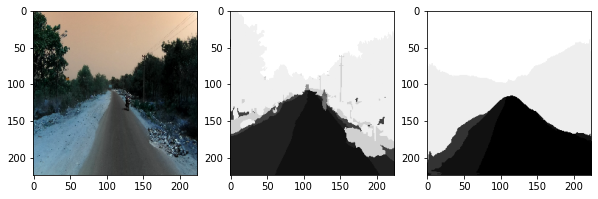

In [ ]:
for p, i in enumerate(X_test):
    #original image

    #image = cv2.imread(list(X_test['image'])[p], cv2.IMREAD_UNCHANGED)
    image = cv2.imread(os.path.join(dir_path, i+'_leftImg8bit.jpg'), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (224,224),interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation map
    #print(np.newaxis)
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(os.path.join(dir_path_output, i+'_gtFine_polygons.png'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (224,224),interpolation = cv2.INTER_NEAREST)
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray') 
    plt.subplot(133)
    plt.imshow(pred_mask[0], cmap='gray')
    plt.show()

    if p == 20:
      break